In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("vard2.csv")

In [3]:
df.head()

,id_job,var_telecommuting,var_logo,var_questions,var_employment_type,var_required_experience,var_required_education,var_industry,var_function,var_pais,var_department,var_salary
0,0,False,True,False,Other,Other,Unspecified,Unknown,Marketing,United States,Marketing,0-20
1,1,False,True,False,Full-time,Not Applicable,Unspecified,Other,Customer Service,Other,Other,0-20
2,2,False,True,False,Unknown,Unknown,Unspecified,Unknown,Unknown,United States,Unknown,0-20
3,3,False,True,False,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,United States,Sales,0-20
4,4,False,True,True,Full-time,Mid-Senior level,Bachelor's Degree,Other,Other,United States,Unknown,0-20


In [4]:
aux = pd.read_csv("fake_job_postings.csv")

In [5]:
aux['job_id'] = aux['job_id']-1

In [6]:
aux = aux[['job_id','fraudulent']]

In [7]:
aux.rename(columns={'job_id':'id_job'},inplace=True)

In [8]:
aux

,id_job,fraudulent
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
17875,17875,0
17876,17876,0
17877,17877,0
17878,17878,0


In [9]:
df = df.merge(aux)

In [10]:
df.shape

(17880, 13)

In [11]:
df.drop(columns='id_job',inplace = True)

In [12]:
df.shape

(17880, 12)

In [13]:
df.rename(columns={'fraudulent':'y'},inplace = True)

## Transformación WoE y cálculo de IV 

In [14]:
varw = [v for v in df.columns if v[:3]=='var']

In [15]:
varw

['var_telecommuting',
 'var_logo',
 'var_questions',
 'var_employment_type',
 'var_required_experience',
 'var_required_education',
 'var_industry',
 'var_function',
 'var_pais',
 'var_department',
 'var_salary']

In [16]:
l_iv = []
for v in varw:
    aux = df[[v,'y']].copy()
    aux['n'] = 1
    aux = aux.pivot_table(index=v,columns='y',values='n',aggfunc='sum',fill_value=0)
    for k in range(2):
        aux[k]/=aux[k].sum() 
    aux['woe'] = np.log(aux[0]/aux[1])
    iv = ((aux[0]-aux[1])*aux['woe']).sum()
    l_iv.append((v,iv))
    aux.drop(range(2),axis=1,inplace=True)
    df['w_%s'%v]=df[v].replace(aux.to_dict()['woe'])

In [17]:
iv = pd.DataFrame(l_iv,columns=['característica','iv']).sort_values('iv',ascending=False).reset_index(drop=True)

In [18]:
iv

,característica,iv
0,var_logo,1.099602
1,var_pais,0.392413
2,var_function,0.360372
3,var_industry,0.281461
4,var_required_education,0.260127
5,var_questions,0.194173
6,var_required_experience,0.179778
7,var_salary,0.133991
8,var_employment_type,0.118899
9,var_department,0.110209


In [19]:
best = iv.loc[(iv.iv>=0.1)]['característica'].to_list()

In [20]:
best

['var_logo',
 'var_pais',
 'var_function',
 'var_industry',
 'var_required_education',
 'var_questions',
 'var_required_experience',
 'var_salary',
 'var_employment_type',
 'var_department']

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,roc_auc_score

In [22]:
modelo = LogisticRegression()

In [47]:
varw = ['w_%s'%v for v in best]
X = df[varw].copy()
y = df['y'].copy()

In [48]:
Xt, Xv, yt,yv = train_test_split(X,y,train_size=0.7)

In [49]:
modelo.fit(Xt,yt)

/home/diegoias/Documents/CieciaDatos/cdd/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [50]:
print(roc_auc_score(y_true=yt,y_score=modelo.predict_proba(Xt)[:,1]))
print(roc_auc_score(y_true=yv,y_score=modelo.predict_proba(Xv)[:,1]))

0.867440771507612
0.8601910342000294


In [51]:
print(accuracy_score(y_true=yt,y_pred=modelo.predict(Xt)))
print(accuracy_score(y_true=yv,y_pred=modelo.predict(Xv)))

0.9546979865771812
0.9537658463832961


In [52]:
modelo.coef_

array([[-0.94683189, -0.81524659, -0.80981564, -0.68298811, -0.59386236,
        -0.29954342, -0.22047419, -1.28940281, -0.6352748 , -1.87006428]])

In [53]:
for v in best:
    aux = df[[v,'y']].copy()
    aux['n'] = 1
    aux = aux.pivot_table(index=v,columns='y',values='n',aggfunc='sum',fill_value=0)
    aux['t'] = aux[range(2)].sum(axis=1)
    for k in range(2):
        aux[k]/=aux['t']
    print(v)
    print('\n')
    print(aux)
    print('\n')

var_logo


y                0         1      t
var_logo                           
False     0.840710  0.159290   3660
True      0.980098  0.019902  14220


var_pais


y                      0         1      t
var_pais                                 
Other           0.976653  0.023347   4840
United Kingdom  0.990352  0.009648   2384
United States   0.931494  0.068506  10656


var_function


y                              0         1     t
var_function                                    
Administrative          0.811111  0.188889   630
Customer Service        0.945484  0.054516  1229
Engineering             0.916172  0.083828  1348
Information Technology  0.981704  0.018296  1749
Marketing               0.987952  0.012048   830
Other                   0.964757  0.035243  4171
Sales                   0.972071  0.027929  1468
Unknown                 0.947792  0.052208  6455


var_industry


y                                           0         1     t
var_industry                        

In [54]:
aux = Xt.copy()
aux['proba'] = modelo.predict_proba(aux)[:,1]
aux['proba'] = pd.cut(aux['proba'],include_lowest=True,bins=np.arange(0,1.1,0.1))

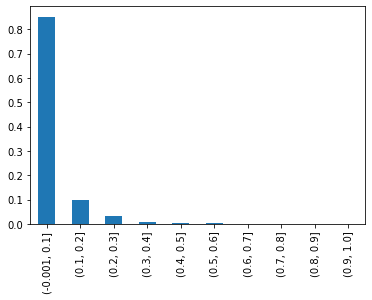

In [55]:
aux.proba.value_counts(True).sort_index().plot(kind='bar')

In [98]:
pdo = 10.6  #Points to double de odd's  
base_score = 326 #score base
base_odds = 1 #odd's base
factor = float(pdo) / np.log(2)
offset = base_score - factor * np.log(base_odds)

In [99]:
n = len(best)
betas = modelo.coef_[0]
alpha = modelo.intercept_[0]
for feat, beta in zip(varw, betas):
    aux['P_' + feat] = np.ceil((-aux[feat] * beta + alpha / n) * factor + offset / n).astype(int)
aux['score'] = aux[[f for f in aux.columns if f[:2] == 'P_']].sum(axis=1)

In [100]:
aux.score.describe()

count    12516.000000
mean       303.500320
std         30.030222
min        206.000000
25%        288.000000
50%        303.000000
75%        318.000000
max        451.000000
Name: score, dtype: float64

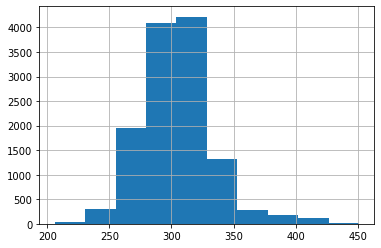

In [101]:
aux.score.hist()

In [102]:
aux['r_score'] = pd.cut(aux.score, bins=range(200,460,20),include_lowest=True)

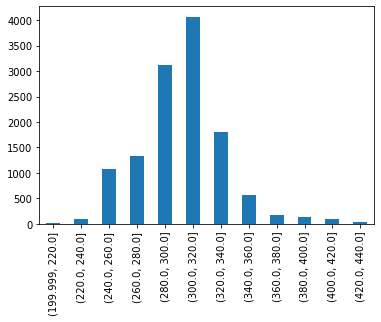

In [103]:
aux.r_score.value_counts().sort_index().plot(kind='bar')

In [104]:
aux['target']  = yt

In [105]:
aux['n']= 1.0

In [106]:
aux[['r_score','proba','target','n']].groupby(['r_score','proba','target']).sum().fillna(0)

n
r_score          proba         target     
(199.999, 220.0] (-0.001, 0.1] 0       0.0
                               1       0.0
                 (0.1, 0.2]    0       0.0
                               1       0.0
                 (0.2, 0.3]    0       0.0
...                                    ...
(420.0, 440.0]   (0.7, 0.8]    1       0.0
                 (0.8, 0.9]    0       0.0
                               1       0.0
                 (0.9, 1.0]    0       0.0
                               1       0.0

[240 rows x 1 columns]

In [107]:
aux = aux.merge(df,left_index=True,right_index=True,how='inner')

In [112]:
aux2

,atributo,puntos,caracteristica
0,Unknown,30,var_department
1,Sales,36,var_department
2,Other,26,var_department
3,Marketing,101,var_department
4,Engineering,4,var_department
5,IT,22,var_department


In [108]:
l_sc = []
for v in best:
    aux2 = aux[[v,"P_w_%s"%v]].copy().drop_duplicates().reset_index(drop=True)
    aux2.rename(columns={v:'atributo',"P_w_%s"%v:'puntos'},inplace=True)
    aux2['caracteristica'] = v
    l_sc.append(aux2)

In [109]:
sc = pd.concat(l_sc,ignore_index=True)

In [110]:
sc.groupby(['caracteristica','atributo']).sum().to_excel('scorecard.xlsx')